The first step of our project will be data downloading and pre-processing before it can enter our CNN. Data is downloaded from a Kaggle Dataset of the ISIC 2019 training data. This training data will then be split into training and validation data. Testing data is also provided by the ISIC 2019 challenge database, and is already split into a separate download. We chose to use kaggle to download our data from, because it is a faster way of interfacing with large datasets through Google Colab because uploading to google drive took too long.


**Note:** for this Colab Notebook to work properly, it is important that each code module is run sequentially.

In [ ]:
#import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import pandas as pd
import os
from torch.utils.data import DataLoader, Subset, random_split
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')
!mkdir -p ~/.kaggle

#random seed set
np.random.seed(42)
torch.manual_seed(42)

######### Set up CUDA to enable GPU for better processing power #########

CUDA_flag = True #change if you don't want to use CUDA

if (torch.cuda.is_available) and (CUDA_flag == True):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'Device: {device}')

Mounted at /content/drive
Device: cuda


In [ ]:
#Lucas

#upload kaggle ID -- kaggle.json file has to be uploaded to colab notebook before running this cell, and must be done
#everytime the runtime is restarted

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


#download the dataset
!kaggle datasets download -d salviohexia/isic-2019-skin-lesion-images-for-classification

#unzip the dataset
!unzip isic-2019-skin-lesion-images-for-classification.zip -d dataset/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/NV/ISIC_0053881.jpg  
  inflating: dataset/NV/ISIC_0053883.jpg  
  inflating: dataset/NV/ISIC_0053886.jpg  
  inflating: dataset/NV/ISIC_0053890.jpg  
  inflating: dataset/NV/ISIC_0053894.jpg  
  inflating: dataset/NV/ISIC_0053896.jpg  
  inflating: dataset/NV/ISIC_0053915.jpg  
  inflating: dataset/NV/ISIC_0053918.jpg  
  inflating: dataset/NV/ISIC_0053920.jpg  
  inflating: dataset/NV/ISIC_0053922.jpg  
  inflating: dataset/NV/ISIC_0053929.jpg  
  inflating: dataset/NV/ISIC_0053931.jpg  
  inflating: dataset/NV/ISIC_0053937.jpg  
  inflating: dataset/NV/ISIC_0053940.jpg  
  inflating: dataset/NV/ISIC_0053948.jpg  
  inflating: dataset/NV/ISIC_0053952.jpg  
  inflating: dataset/NV/ISIC_0053959.jpg  
  inflating: dataset/NV/ISIC_0053970.jpg  
  inflating: dataset/NV/ISIC_0053975.jpg  
  inflating: dataset/NV/ISIC_0053982.jpg  
  inflating: dataset/NV/ISIC_0053983.jpg  
  inflating: dataset/NV/ISIC_0053992.jpg  
  i

Final stages of data preprocessing is to resize the images, and then split it into our training and validation dataset.

In [ ]:
import os
import shutil

# Define the dataset path
dataset_path = "/content/dataset"  # Change this to your actual dataset path

# Define new category folders
cancerous_folder = os.path.join(dataset_path, "cancerous")
non_cancerous_folder = os.path.join(dataset_path, "non-cancerous")

# Create new folders if they don't exist
os.makedirs(cancerous_folder, exist_ok=True)
os.makedirs(non_cancerous_folder, exist_ok=True)

# Define class mappings
cancerous_classes = ["MEL", "BCC", "AK", "SCC"]
non_cancerous_classes = ["NV", "BKL", "DF", "VASC"]

# Function to move images
def move_images(class_list, destination_folder):
    for class_name in class_list:
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.exists(class_folder):
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                shutil.move(img_path, destination_folder)  # Move file
            print(f"Moved all images from {class_name} to {destination_folder}")

# Move cancerous images
move_images(cancerous_classes, cancerous_folder)

# Move non-cancerous images
move_images(non_cancerous_classes, non_cancerous_folder)

binary_dataset_path = "/content/binary_dataset"
os.makedirs(binary_dataset_path, exist_ok=True)

# Move the folders
shutil.move(cancerous_folder, os.path.join(binary_dataset_path, "cancerous"))
shutil.move(non_cancerous_folder, os.path.join(binary_dataset_path, "non-cancerous"))

print("Moved cancerous and non-cancerous folders to /content/binary_dataset")
print("Dataset reorganization complete.")


Moved all images from MEL to /content/dataset/cancerous
Moved all images from BCC to /content/dataset/cancerous
Moved all images from AK to /content/dataset/cancerous
Moved all images from SCC to /content/dataset/cancerous
Moved all images from NV to /content/dataset/non-cancerous
Moved all images from BKL to /content/dataset/non-cancerous
Moved all images from DF to /content/dataset/non-cancerous
Moved all images from VASC to /content/dataset/non-cancerous
Moved cancerous and non-cancerous folders to /content/binary_dataset
Dataset reorganization complete.


In [ ]:
import os
import shutil
import random

# Paths to folders
dataset_path = "/content/binary_dataset"  # Change if needed
cancerous_path = os.path.join(dataset_path, "cancerous")
non_cancerous_path = os.path.join(dataset_path, "non-cancerous")

# Get image lists
cancerous_images = os.listdir(cancerous_path)
non_cancerous_images = os.listdir(non_cancerous_path)

# Count images
num_cancerous = len(cancerous_images)
num_non_cancerous = len(non_cancerous_images)

print(f"Cancerous: {num_cancerous}, Non-Cancerous: {num_non_cancerous}")

# Check if balancing is needed
if num_cancerous < num_non_cancerous:
    deficit = num_non_cancerous - num_cancerous
    print(f"Duplicating {deficit} cancerous images to balance the dataset...")

    for i in range(deficit):
        src_img = random.choice(cancerous_images)
        src_path = os.path.join(cancerous_path, src_img)

        # Create a unique filename for the duplicated image
        new_filename = f"dup_{i}_{src_img}"
        dst_path = os.path.join(cancerous_path, new_filename)

        shutil.copy(src_path, dst_path)

    print("Cancerous class balancing complete.")
else:
    print("No balancing needed — cancerous class already has enough images.")


Cancerous: 9340, Non-Cancerous: 15991
Duplicating 6651 cancerous images to balance the dataset...
Cancerous class balancing complete.


In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 1. Define transform
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
   # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])

# 2. Define dataset path
dataset_path = "/content/binary_dataset"  # should contain 'cancerous' and 'non-cancerous'

# 3. Use ImageFolder (it automatically assigns numeric labels based on folder names alphabetically)
# 'cancerous' => 0 or 1 (depends on sorting)
# We'll fix that in a sec.
dataset = datasets.ImageFolder(root=dataset_path, transform=base_transform)

# Check current class-to-index mapping
print("Class to index mapping:", dataset.class_to_idx)
# If 'cancerous': 0 and 'non-cancerous': 1, we can swap it like this:
dataset.class_to_idx = {'non-cancerous': 0, 'cancerous': 1}
dataset.samples = [(p, dataset.class_to_idx[os.path.basename(os.path.dirname(p))]) for p, _ in dataset.samples]
transformed_images = []
for img, label in dataset:
    transformed_images.append((img, label))


# Define the train-validation split ratio
train_ratio = 0.8  # 80% train, 20% validation
train_size = int(train_ratio * len(transformed_images))
val_size = len(transformed_images) - train_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(transformed_images, [train_size, val_size])
# 4. Split into train and val sets (e.g. 80% train, 20% val)

'''
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])
'''

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Class to index mapping: {'cancerous': 0, 'non-cancerous': 1}
Total dataset size: 31982
Training set size: 25585
Validation set size: 6397


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define paths
path_to_test_truths = '/content/drive/MyDrive/APS360_Project/ISIC_2019_Test_GroundTruth.csv'
path_to_folder = '/content/drive/MyDrive/APS360_Project/Testing_Data/ISIC_2019_Test_Input'

# Read ground truth CSV and drop unwanted columns
test_truths = pd.read_csv(path_to_test_truths)
test_truths = test_truths.drop(columns=['validation_weight', 'score_weight'])


# Define the class mapping dictionary
indexed_class = {"AK": 1, "BCC": 1, "BKL": 0, "DF": 0, "MEL": 1, "NV": 0, "SCC": 1, "VASC": 0}

class ISICTestDataset(Dataset):
    def __init__(self, image_folder, truth_csv, class_mapping, transform=None):
        """
        Args:
            image_folder (str): Path to the folder containing the images.
            truth_csv (str): Path to the CSV file containing the ground truth labels.
            class_mapping (dict): Mapping of class names to numeric labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_folder = image_folder
        self.truth_csv = pd.read_csv(truth_csv)
        self.truth_csv = self.truth_csv.drop(columns=['validation_weight', 'score_weight'])
        self.class_mapping = class_mapping
        self.transform = transform
        self.printer= True

        # Create a list of image filenames and corresponding labels
        self.image_labels = []
        for file_name in os.listdir(image_folder):
            if file_name.lower().endswith(".jpg"):
                base_filename = os.path.splitext(file_name)[0]
                row = self.truth_csv[self.truth_csv['image'] == base_filename]
                if not row.empty:
                    found_label = None
                    for label_col in self.class_mapping.keys():
                        if row[label_col].iloc[0] == 1:
                            found_label = label_col
                            break
                    if found_label is not None:
                        found_index = self.class_mapping[found_label]
                        self.image_labels.append((file_name, found_index))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_name, label = self.image_labels[idx]
        img_path = os.path.join(self.image_folder, img_name)
        img = Image.open(img_path).convert("RGB")
        if self.printer:
            print(f"Image name: {img_name}, Label: {label}")
            self.printer = False
        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

# Define the transformations (resizing to 224x224)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use the same normalization as training
])

# Create dataset and dataloaders
test_dataset = ISICTestDataset(image_folder=path_to_folder,
                               truth_csv=path_to_test_truths,
                               class_mapping=indexed_class,
                               transform=test_transform)
transformed_test_images = []
for img, label in test_dataset:
    transformed_test_images.append((img, label))



Image name: ISIC_0070188.jpg, Label: 1


#**Model**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class FineTuneResNet(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.5):
        super(FineTuneResNet, self).__init__()
        # Load a pretrained ResNet-50
        self.name = "FineTuneResNet"
        resnet = models.resnet50(pretrained=True)

        # Remove the last two layers (avgpool and fc) by taking all layers up to layer4
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze the feature extractor parameters
        for param in self.features.parameters():
            param.requires_grad = False

        # 1x1 convolution to reduce channel dimensions from 2048 to 256
        self.conv_reduce = nn.Conv2d(2048, 256, kernel_size=1)

        # Optionally, add BatchNorm after conv_reduce to stabilize training
        self.bn = nn.BatchNorm2d(256)

        # Global average pooling layer
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers with dropout to reduce overfitting
        self.fc = nn.Linear(256, 128)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer

        # Final classification layer (1 output for binary classification)
        self.fc2 = nn.Linear(128, num_classes)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Extract features using ResNet (up to layer4)
        x = self.features(x)  # shape: (batch, 2048, H, W)

        # Reduce channel dimension
        x = self.conv_reduce(x)  # shape: (batch, 256, H, W)
        x = self.bn(x)           # Apply batch normalization
        x = self.relu(x)         # Non-linearity

        # Apply pooling to collapse spatial dimensions to 1x1
        x = self.pool(x)  # shape: (batch, 256, 1, 1)

        # Flatten the tensor: (batch, 256)
        x = torch.flatten(x, 1)

        # Fully connected layer with dropout and ReLU
        x = self.fc(x)    # shape: (batch, 128)
        x = self.relu(x)

        # Final classification layer (output raw logits)
        x = self.fc2(x)   # shape: (batch, 1)
        return x


![Alt Text](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*VM94wVftxP7wkiKo4BjfLA.png)


#**Base line model**

The baseline model is a simple CNN composed of 3 CNN layers followed by 3 FC ANN layers. The Training, validation, and helper functions were adapted from Labs 2 and 3.

In [ ]:
# Declare DataLoaders and subsets
batch_size = 128
numworkers=12
# DataLoader with num_workers=4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=numworkers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=numworkers)

# Subset DataLoader with num_workers=4
#train_subset = Subset(train_dataset, range(5000))
#val_subset = Subset(val_dataset, range(500))

#train_subset_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=numworkers)
#val_subset_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=numworkers)

# Test DataLoader with num_workers=4
test_loader = torch.utils.data.DataLoader(transformed_test_images, batch_size=batch_size, shuffle=False,num_workers=numworkers)

# Install seaborn (if required)

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
class BaseLine(nn.Module):
    def __init__(self, num_classes=1):
        super(BaseLine, self).__init__()
        self.name = "BaseLine"
        # 3-layer CNN
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)  # Output: (32, 224, 224)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) # Output: (64, 112, 112)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # Output: (128, 56, 56)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Halves spatial dimensions

        # Flattening size after CNN layers
        self.flatten_size = 32 * 28 * 28  # Computed from conv3 output

        # 3-layer Fully Connected ANN
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # CNN Forward Pass
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # (8, 112, 112)

        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (16, 56, 56)

        x = F.relu(self.conv3(x))
        x = self.pool(x)  # (32, 28, 28)

        # Flatten
        x = x.view(x.size(0), -1) # (batch_size, 32 * 28 * 28)

        # Fully Connected ANN
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation, as CrossEntropyLoss applies softmax

        return x

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, val_loader, device, lr, num_epochs, filename, batch_size, lossfn=nn.BCEWithLogitsLoss()):
    # Arrays for storing plottable metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Move the model to the device
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Initialize variables to track best model
    best_val_acc = 0.0
    best_model = None

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        tr_loss = 0.0
        train_correct = 0
        train_total = 0

        # Train model and calculate loss and accuracy
        for images, labels in train_loader:
            images = images.to(device)
            # Convert labels to float and reshape to [batch_size, 1]
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()

            y_pred = model(images)  # shape: (batch, 1)
            loss = lossfn(y_pred, labels)

            loss.backward()
            optimizer.step()

            tr_loss += loss.item()
            # For BCEWithLogitsLoss, apply threshold of 0 on logits
            predicted = (y_pred > 0).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = tr_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = train_correct / train_total
        train_accuracies.append(train_acc)

        # Validate model and calculate loss and accuracy; set model to evaluation mode
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = lossfn(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs > 0).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Save the model with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()  # Save the best model state

    # Save the best model
    if best_model is not None:
        torch.save(best_model, f"best_{filename}_{batch_size}_{lr}_{num_epochs}.pth")
        print(f"Best model saved as best_{filename}_{batch_size}_{lr}_{num_epochs}.pth")

    # Plot Losses
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

    # Plot Accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.show()




def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model, model_path, test_loader, device):
    """
    Evaluates the model on test data, printing overall accuracy, confusion matrix,
    and classification report.

    Args:
      model: The model class or instance.
      model_path: Path to the saved model state.
      test_loader: DataLoader for the test dataset.
      device: Device to use (e.g., 'cuda' or 'cpu').
    """
    # Load model weights
    model_instance = model
    model_instance.load_state_dict(torch.load(model_path, map_location=device))
    model_instance.to(device)
    model_instance.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_instance(images)  # shape: [batch_size, 1]

            # Binary prediction using threshold of 0 (logit > 0 <=> sigmoid > 0.5)
            preds = (outputs > 0).float().squeeze(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Total accuracy
    total_accuracy = np.mean(all_preds == all_labels)
    print("Total Accuracy: {:.2f}%".format(total_accuracy * 100))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report (precision, recall, f1)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"]))





/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40: Train Loss: 0.6931, Val Loss: 0.6838, Train Acc: 0.5146, Val Acc: 0.5492
Epoch 2/40: Train Loss: 0.6739, Val Loss: 0.6632, Train Acc: 0.6054, Val Acc: 0.6841
Epoch 3/40: Train Loss: 0.6568, Val Loss: 0.6459, Train Acc: 0.6585, Val Acc: 0.7119
Epoch 4/40: Train Loss: 0.6397, Val Loss: 0.6303, Train Acc: 0.6915, Val Acc: 0.7208
Epoch 5/40: Train Loss: 0.6247, Val Loss: 0.6157, Train Acc: 0.7039, Val Acc: 0.7241
Epoch 6/40: Train Loss: 0.6108, Val Loss: 0.6016, Train Acc: 0.7127, Val Acc: 0.7289
Epoch 7/40: Train Loss: 0.5975, Val Loss: 0.5886, Train Acc: 0.7185, Val Acc: 0.7349
Epoch 8/40: Train Loss: 0.5849, Val Loss: 0.5763, Train Acc: 0.7250, Val Acc: 0.7388
Epoch 9/40: Train Loss: 0.5734, Val Loss: 0.5647, Train Acc: 0.7318, Val Acc: 0.7443
Epoch 10/40: Train Loss: 0.5634, Val Loss: 0.5541, Train Acc: 0.7351, Val Acc: 0.7482
Epoch 11/40: Train Loss: 0.5537, Val Loss: 0.5443, Train Acc: 0.7409, Val Acc: 0.7522
Epoch 12/40: Train Loss: 0.5444, Val Loss: 0.5353, Train Acc: 0

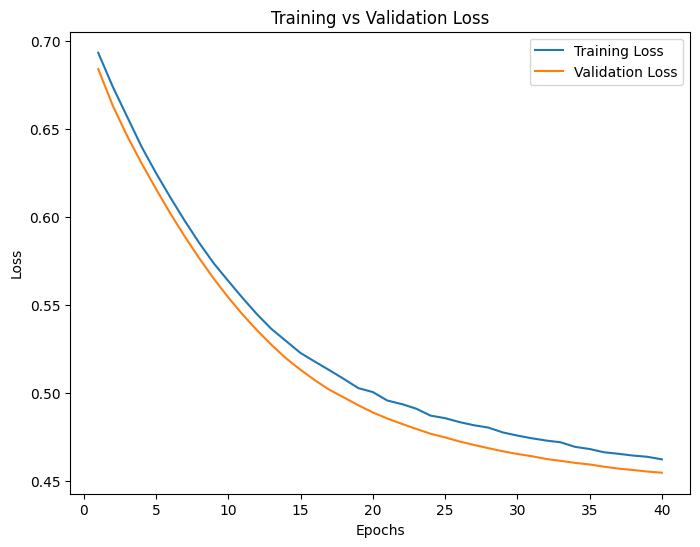

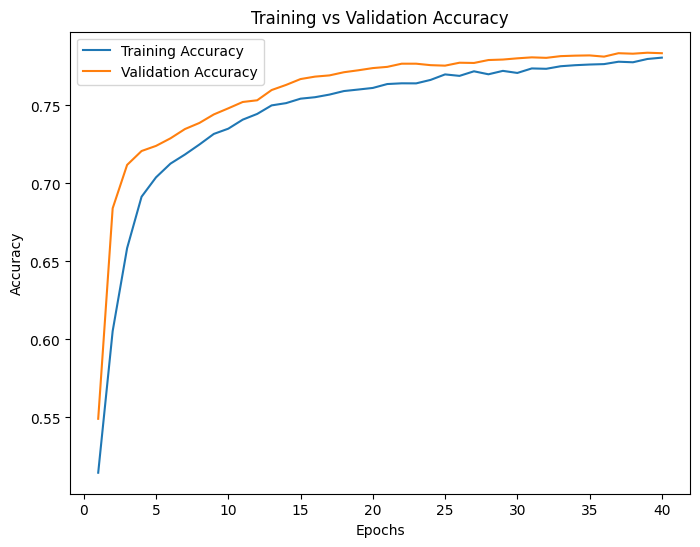

In [ ]:
model_main=FineTuneResNet()

train_and_validate(model_main, train_loader, val_loader, device, lr=0.00001, num_epochs=40, filename=model_main.name, batch_size=batch_size)
#evaluate_model(model_main, test_loader, device, class_names=class_names)

In [ ]:
mode=BaseLine()

train_and_validate(mode, train_loader, val_loader, device, lr=0.001, num_epochs=20, filename=mode.name, batch_size=batch_size)
#evaluate_model(mode, test_loader, device, class_names=class_names)

Epoch 1/20: Train Loss: 0.6203, Val Loss: 0.5996, Train Acc: 0.6576, Val Acc: 0.6670
Epoch 2/20: Train Loss: 0.5785, Val Loss: 0.5723, Train Acc: 0.6934, Val Acc: 0.7081
Epoch 3/20: Train Loss: 0.5601, Val Loss: 0.5503, Train Acc: 0.7082, Val Acc: 0.7252
Epoch 4/20: Train Loss: 0.5403, Val Loss: 0.5433, Train Acc: 0.7225, Val Acc: 0.7197
Epoch 5/20: Train Loss: 0.5290, Val Loss: 0.5594, Train Acc: 0.7315, Val Acc: 0.7171


KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Accuracy: 76.26%


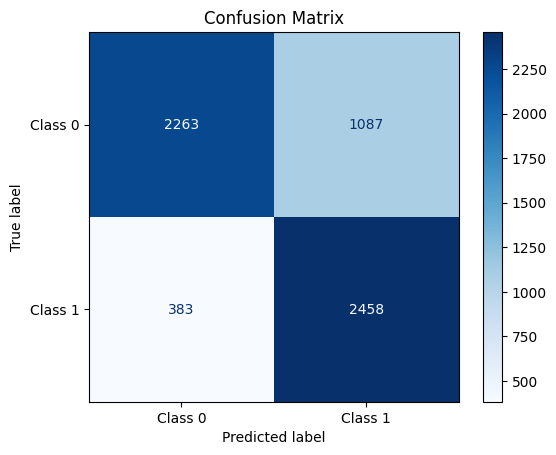


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.68      0.75      3350
     Class 1       0.69      0.87      0.77      2841

    accuracy                           0.76      6191
   macro avg       0.77      0.77      0.76      6191
weighted avg       0.78      0.76      0.76      6191



In [ ]:
mod=FineTuneResNet()

evaluate_model(mod,
               model_path="/content/best_FineTuneResNet_1024_1e-05_40.pth",
               test_loader=test_loader,
               device=device)

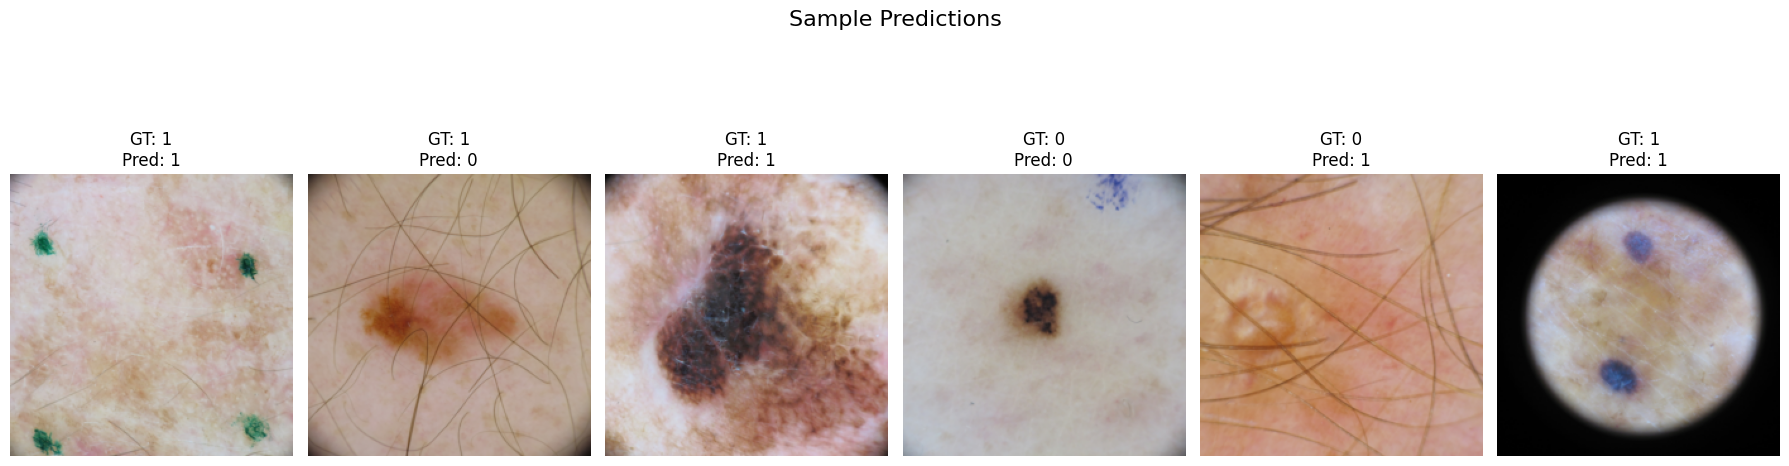

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, model_path, dataset, device, num_samples=6):


    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(1, num_samples, figsize=(18, 6))

    for i in range(num_samples):
        img, label = dataset[i]
        input_img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            pred = (output > 0).float().item()

        img_disp = img.permute(1, 2, 0).cpu().numpy()

        axes[i].imshow(img_disp)
        axes[i].set_title(f"GT: {int(label)}\nPred: {int(pred)}", fontsize=12)
        axes[i].axis("off")

    plt.suptitle("Sample Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_predictions(
    model=mod,
    model_path="/content/best_FineTuneResNet_1024_1e-05_40.pth",
    dataset=transformed_test_images,
    device=device,
    num_samples=6
)



Total Accuracy: 71.70%


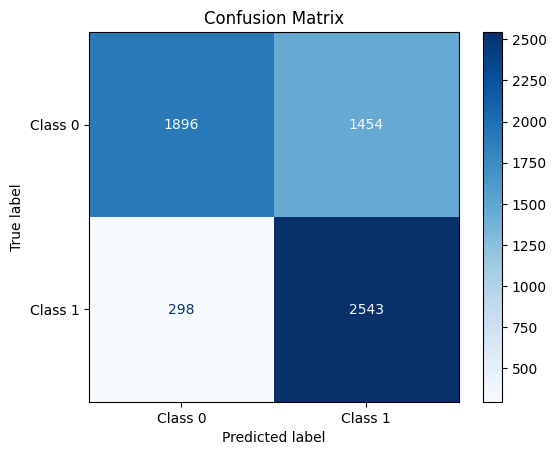


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.57      0.68      3350
     Class 1       0.64      0.90      0.74      2841

    accuracy                           0.72      6191
   macro avg       0.75      0.73      0.71      6191
weighted avg       0.76      0.72      0.71      6191



In [ ]:
mode=BaseLine()

evaluate_model(mode,
               model_path="/content/best_BaseLine_64_0.0001_22.pth",
               test_loader=test_loader,
               device=device)